# Semantic Segmentation for Autonomous Vehicles using Cityscapes dataset

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Environment checks

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
print(tf.executing_eagerly())

True


## Data preparation - Importing, Cleaning and Creating structured directory 

### Functions to read and separate frames from masks

In [6]:
def _read_to_tensor(fname, output_height=256, output_width=512, normalize_data=False):
    '''Original images are 256 x 512 x 3. Left half is original image, right is semantic seg'''
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    if normalize_data:
        output = (output - 128) / 128
    return output

def _get_left_img_half(inp, width=256):
    return inp[:, :width, :]

def _get_right_img_half(inp, width=256):
    return inp[:, width:, :]

### Reading and separating frames and masks

In [7]:
train_img_dir = 'data/cityscapes_data/train'
val_img_dir = 'data/cityscapes_data/val'

# Start with a dataset of directory names.
output_height = 256
output_width = 256

def separate_frames_masks(img_dir):
    file_list = os.listdir(img_dir)
    img_paths = [os.path.join(img_dir, fname) for fname in file_list]
    my_data = tf.data.Dataset.from_tensor_slices(img_paths)
    img_tensors = my_data.map(_read_to_tensor)
    frames = img_tensors.map(_get_left_img_half)
    masks = img_tensors.map(_get_right_img_half)
    return frames, masks, file_list

train_frames, train_masks, train_files = separate_frames_masks(train_img_dir)
val_frames, val_masks, val_files = separate_frames_masks(val_img_dir)

### Displaying Images in the train dataset

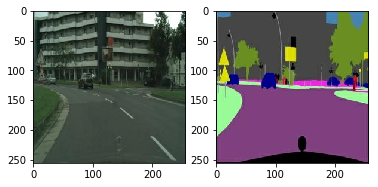

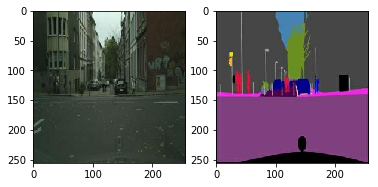

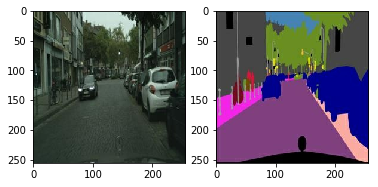

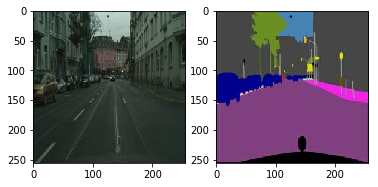

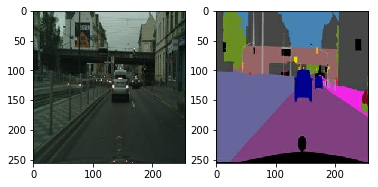

In [8]:
frame_batches = tf.compat.v1.data.make_one_shot_iterator(train_frames)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(train_masks)
n_images_to_show = 5

for i in range(n_images_to_show):

    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

### Creating folder structure common to Computer Vision problems

In [8]:
DATA_PATH = 'data/cityscapes_data/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[WinError 183] Cannot create a file when that file already exists: 'data/cityscapes_data/train_frames/train'
[WinError 183] Cannot create a file when that file already exists: 'data/cityscapes_data/train_masks/train'
[WinError 183] Cannot create a file when that file already exists: 'data/cityscapes_data/val_frames/val'
[WinError 183] Cannot create a file when that file already exists: 'data/cityscapes_data/val_masks/val'


### Saving frames and masks to correct directories

In [9]:
def generate_image_folder_structure(frames, masks, files, dir_name):
    
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the images while saving the frames and masks in appropriate folders
    for file in files:
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file)
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file)
    
    print("Saved {} frames to directory {}".format(len(files),DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'))
    print("Saved {} masks to directory {}".format(len(files),DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'))
    
generate_image_folder_structure(train_frames, train_masks, train_files, 'train')

generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 2975 frames to directory data/cityscapes_data/train_frames/train/
Saved 2975 masks to directory data/cityscapes_data/train_masks/train/
Saved 500 frames to directory data/cityscapes_data/val_frames/val/
Saved 500 masks to directory data/cityscapes_data/val_masks/val/


# Creating Data generators

### Defining data generators

In [14]:
batch_shape=(8,256,256,3)
classes=21
img_input = Input(batch_shape=batch_shape)
img_input

<tf.Tensor 'input_1:0' shape=(8, 256, 256, 3) dtype=float32>

In [72]:
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict(rescale=1./255)
train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

seed = 1

### Custom generators for creating batches of frames and masks

In [74]:


def TrainAugmentGenerator(seed = 1, batch_size = 5):
    train_image_generator = train_frames_datagen.flow_from_directory(
    'data/cityscapes_data/train_frames/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    'data/cityscapes_data/train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        yield X1i[0], X2i[0]

def ValAugmentGenerator(seed = 1, batch_size = 5):
    val_image_generator = val_frames_datagen.flow_from_directory(
    'data/cityscapes_data/val_frames/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    'data/cityscapes_data/val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        yield X1i[0], X2i[0]
        


# Defining U-Net model for semantic segmentation

In [19]:
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    
    batch_shape=(256,256,3)
    
    inputs = Input(batch_shape=(5, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(3, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

## Generating U-Net model 

In [20]:
model = get_small_unet(n_filters = 32)

Tensor("input_2:0", shape=(5, 256, 256, 3), dtype=float32)


## Defining dice co-efficients for model performance

In [21]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [23]:
smooth = 1.

## Compiling model

In [24]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[IOU_calc,'accuracy'])


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(5, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (5, 256, 256, 32)    896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (5, 256, 256, 32)    128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (5, 256, 256, 32)    9248        batch_normalization_v2[0][0]     
______________________________________________________________________________________________

In [68]:
#model.load_weights("model_100_epochs.h5")

## Define model callback settings

In [82]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='model_150_epochs_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='accuracy', patience=6, verbose=1)
callbacks = [tb, mc, es]

## Train and save the U-Net model

In [83]:
# Train model

batch_size = 5
model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=np.ceil(float(len(train_files)) / float(batch_size)) ,
                validation_data = ValAugmentGenerator(), 
                validation_steps = (float(len(val_files)) / float(batch_size)), epochs=150, callbacks=callbacks)
model.save_weights("model_150_epochs.h5", overwrite=True)

Found 2975 images belonging to 1 classes.
Found 2975 images belonging to 1 classes.
Epoch 1/150
594/595 [============================>.] - ETA: 0s - loss: 1.1074 - IOU_calc: 0.3768 - accuracy: 0.5663Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.

Epoch 00001: accuracy improved from -inf to 0.56598, saving model to model_150_epochs_checkpoint.h5
595/595 [==============================] - 165s 277ms/step - loss: 1.1073 - IOU_calc: 0.3768 - accuracy: 0.5660 - val_loss: 1.0842 - val_IOU_calc: 0.3800 - val_accuracy: 0.6571
Epoch 2/150
594/595 [============================>.] - ETA: 0s - loss: 1.0937 - IOU_calc: 0.3831 - accuracy: 0.6069
Epoch 00002: accuracy improved from 0.56598 to 0.60720, saving model to model_150_epochs_checkpoint.h5
595/595 [==============================] - 150s 252ms/step - loss: 1.0935 - IOU_calc: 0.3831 - accuracy: 0.6072 - val_loss: 1.0800 - val_IOU_calc: 0.3813 - val_accuracy: 0.6990
Epoch 3/150
594/595 [========================

Epoch 44/150
594/595 [============================>.] - ETA: 0s - loss: 1.0612 - IOU_calc: 0.4002 - accuracy: 0.6847
Epoch 00044: accuracy did not improve from 0.69231
595/595 [==============================] - 147s 247ms/step - loss: 1.0613 - IOU_calc: 0.4002 - accuracy: 0.6849 - val_loss: 1.0565 - val_IOU_calc: 0.3939 - val_accuracy: 0.7626
Epoch 45/150
594/595 [============================>.] - ETA: 0s - loss: 1.0620 - IOU_calc: 0.3999 - accuracy: 0.6848
Epoch 00045: accuracy did not improve from 0.69231
595/595 [==============================] - 148s 249ms/step - loss: 1.0619 - IOU_calc: 0.3998 - accuracy: 0.6849 - val_loss: 1.0407 - val_IOU_calc: 0.3999 - val_accuracy: 0.7631
Epoch 46/150
594/595 [============================>.] - ETA: 0s - loss: 1.0599 - IOU_calc: 0.4008 - accuracy: 0.6973
Epoch 00046: accuracy improved from 0.69231 to 0.69732, saving model to model_150_epochs_checkpoint.h5
595/595 [==============================] - 148s 249ms/step - loss: 1.0600 - IOU_calc: 0.40

# Model Evaluation

In [75]:
#testing_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

## Extract and display model frame, prediction and mask batch

In [78]:

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)


(5, 256, 256, 3)

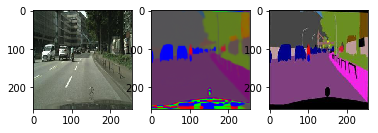

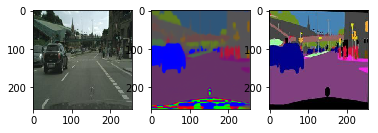

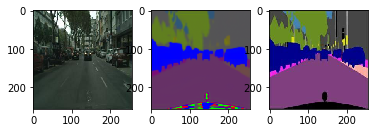

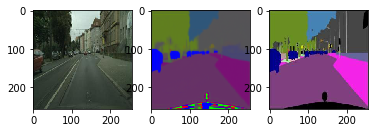

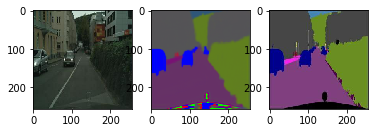

In [77]:
for i in range(0,np.shape(pred_all)[0]):
    fig = plt.figure()
    fig.add_subplot(1,3,1)
    plt.imshow(batch_img[i])
    fig.add_subplot(1,3,2)
    plt.imshow(pred_all[i])
    fig.add_subplot(1,3,3)
    plt.imshow(batch_mask[i])
    plt.show()